In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads=4
from torch import nn
from torchsummary import summary

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anm

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy
import scipy.io

np.random.seed(123)

In [2]:
mod = "Ensemble_PIPNet_2022_03_01_noise_001"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}/"

overwrite = False

load_model = True

eval_history = True
#sel_history = "all"
#sel_history = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
sel_history = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199]

n_samples = 4

eval_evolution = True
#sel_chk = "all"
#sel_chk = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
sel_chk = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199]

eval_custom = False
n_custom = 4

eval_broad_iso = False
broad_iso_factors = [2., 5., 10.]

eval_broad_mas = False
broad_mas_factors = [2., 5., 10.]

eval_sparse = False

eval_noise = False
noise_levels = [1e-5, 1e-4, 1e-3]

vis_filters = False
max_filt = 4
max_smpl = 1

eval_exp = False
evals = {"sel": True, "opt": True, "all": True, "high": True, "low": True, "rand": 0}
x_scales = [0.1, 0.2, 0.3]
exp_dir = f"../data/experimental_spectra/topspin/2048/"
iso_dir = "../data/experimental_spectra/iso/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine", "mdma"]
exp_range = {"ampicillin": [750, 1250],
             "aspala": [750, 1250],
             "flutamide": [750, 1250],
             "histidine": [750, 1250],
             "thymol": [750, 1250],
             "tyrosine": [750, 1250],
             "mdma": [800, 1200],
            }
exp_res = {"ampicillin": ["4k", "4k", "4k", "4k"],
           "aspala": ["4k", "4k", "4k", "4k", "4k"],
           "flutamide": ["2k", "2k", "2k", "2k"],
           "histidine": ["4k", "4k", "4k", "4k", "4k"],
           "thymol": ["4k", "4k", "4k", "4k"],
           "tyrosine": ["4k", "4k", "4k", "4k", "4k"],
           "mdma": ["4k", "4k", "4k", "4k"]}
exp_parts = {'ampicillin': ['NH3', 'NHAr5', 'Ar6104b', 'Me2'],
             'aspala': ['OH', 'NHNH3', 'CHCH', 'CH2', 'CH3'],
             'flutamide': ['H5b', 'H38', 'H6', 'H101112'],
             'histidine': ['H5', 'H7', 'H618', 'H9', 'H342'],
             'thymol': ['H7', 'H321c', 'H4', 'H556'],
             'tyrosine': ['COOH', 'OH', 'NH3H76', 'H5823', 'H3dia'],
             "mdma": ["R1ph_og_divby1456", "R2ph_og_divby1456", "R3ph_og_divby1456", "R4ph_og_divby1456"]}
#sel_wrs = [30000., 33000., 36000., 40000., 43000., 46000., 50000., 53000.,
#           56000., 60000., 63000., 66000., 70000., 73000., 76000., 80000.]

opt_range = [40000., 100000.]

sel_wrs = [40000., 42000., 44000., 46000., 48000.,
           50000., 52000., 54000., 56000., 58000.,
           60000., 62000., 64000., 66000., 68000.,
           70000., 72000., 74000., 76000., 78000., 80000.]

peaks = {"ampicillin": [[0.25, 0.7], [1.3, 1.7], [3.5, 4.1], [4.3, 4.7], [4.8, 5.2], [6.1, 6.6], [9.5, 10.5]],
         "aspala": [[0.5, 1.], [1.9, 2.2], [2.3, 3.], [3.7, 4.1], [4.5, 5.], [7., 7.5], [7.7, 8.2], [12.3, 12.8]],
         "flutamide": [[0.7, 1.5], [1.8, 2.2]],
         "histidine": [[2.3, 2.9], [2.8, 3.5], [4.8, 5.2], [7.2, 7.8], [8.6, 9.2], [12, 12.8], [16.7, 17.4]],
         "thymol": [[0.2, 0.7], [0.8, 1.3], [1.3, 1.8], [3, 3.5], [5, 5.7], [5.7, 6.4], [6.7, 7.2], [9, 9.5]],
         "tyrosine": [[2.3, 2.7], [6.4, 6.8], [9.7, 10.2]],
         "mdma": [[0., 1.6]]}

eval_exp_4k = True
evals_4k = {"sel": True, "opt": True, "all": True, "high": True, "low": True, "rand": 0}
exp_dir_4k = f"../data/experimental_spectra/topspin/4096/"
x_scales_4k = [0.2]
exp_compounds_4k = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine", "mdma"]
exp_range_4k = {"ampicillin": [1500, 2500],
             "aspala": [1500, 2500],
             "flutamide": [1500, 2500],
             "histidine": [1500, 2500],
             "thymol": [1500, 2500],
             "tyrosine": [1500, 2500],
             "mdma": [1600, 2400],
            }

int_regions = {"ampicillin": [[12., 8.5], [8.5, 3.], [3., -2.]],
               "aspala": [[15., 10.], [10., 6.], [6., 3.4], [3.4, 1.5], [1.5, 0.]],
               "flutamide": [[11., 9.], [9., 5.], [5., -2.]],
               "histidine": [[20., 15.], [15., 10.5], [10.5, 6.5], [6.5, 4.2], [4.2, -2.]],
               "thymol": [[12., 8.], [8., 4.5], [4.5, 2.7], [2.7, -2]],
               "tyrosine": [[14., 11.], [11., 9.], [9., 6.1], [6.1, 3.5], [3.5, 0.]],
               "mdma": [[13., 8.], [8., 5.], [5., -1.]],
              }

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
def clean_split(l, delimiter):
    """
    Split a line with the desired delimiter, ignoring delimiters present in arrays or strings
    
    Inputs: - l     Input line
    
    Output: - ls    List of sub-strings making up the line
    """
    
    # Initialize sub-strings
    ls = []
    clean_l = ""
    
    # Loop over all line characters
    in_dq = False
    in_sq = False
    arr_depth = 0
    for li in l:
        # Identify strings with double quotes
        if li == "\"":
            if not in_dq:
                in_dq = True
            else:
                in_dq = False
        
        # Identify strings with single quotes
        if li == "\'":
            if not in_sq:
                in_sq = True
            else:
                in_sq = False
        
        # Identify arrays
        if li == "[":
            if not in_sq and not in_dq:
                arr_depth += 1
        if li == "]":
            if not in_sq and not in_dq:
                arr_depth -= 1
        
        # If the delimiter is not within quotes or in an array, split the line at that character
        if li == delimiter and not in_dq and not in_sq and arr_depth == 0:
            ls.append(clean_l)
            clean_l = ""
        else:
            clean_l += li
    
    ls.append(clean_l)
        
    return ls

In [5]:
def get_array(l):
    """
    Get the values in an array contained in a line
    
    Input:  - l         Input line
    
    Output: - vals      Array of values
    """
    
    # Identify empty array
    if l.strip() == "[]":
        return []
    
    # Initialize array
    vals = []
    clean_l = ""
    
    # Loop over all line characters
    arr_depth = 0
    for li in l:
    
        # Identify end of array
        if li == "]":
            arr_depth -= 1
            
            # Check that there are not too many closing brackets for the opening ones
            if arr_depth < 0:
                raise ValueError("Missing \"[\" for matching the number of \"]\"")
        
        # If we are within the array, extract the character
        if arr_depth > 0:
            clean_l += li
    
        # Identify start of array
        if li == "[":
            arr_depth += 1
    
    # Check that the array is properly closed at the end
    if arr_depth > 0:
        raise ValueError("Missing \"]\" for matching the number of \"[\"")
    
    # Extract elements in the array
    ls = clean_split(clean_l, ",")
    
    # Get the value of each element in the array
    for li in ls:
        vals.append(get_val(li.strip()))

    return vals

In [6]:
def get_val(val):
    
    # Remove tailing comma
    if val.endswith(","):
        val = val[:-1]
    
    # Float / Int
    if val.isnumeric():
        
        if "." in val:
            return float(val)
        else:
            return int(val)
    
    # Bool
    if val.lower() == "true":
        return True
    if val.lower() == "false":
        return False
    
    # String
    if val.startswith("\""):
        return val.split("\"")[1]
    
    # List
    if val.startswith("["):
        
        return get_array(val)
    
    # Try to return a float anyway
    return float(val)

In [7]:
# Get model architecture
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

model_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "model_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        key, val = L.split("=")
        
        v = get_val(val.strip())
        
        model_pars[key.strip()] = v

model_pars["noise"] = 0.

In [8]:
# Get data parameters
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

data_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "data_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        if "=" in L:
        
            key, val = L.split("=")
        
            v = get_val(val.strip())
        
            data_pars[key.strip()] = v

dataset = data.PIPDatasetGLS(**data_pars)

In [9]:
# Get loss parameters
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

loss_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "loss_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        if "=" in L:
        
            key, val = L.split("=")
        
            v = get_val(val.strip())
        
            loss_pars[key.strip()] = v
            
loss_components = []
loss_components_with_tot = ["Total"]

if "srp_w" in loss_pars and loss_pars["srp_w"] > 0.:
    loss_components.append("Sharp component")
    loss_components_with_tot.append("Sharp component")
if "brd_w" in loss_pars and loss_pars["brd_w"] > 0.:
    loss_components.append("Broad component")
    loss_components_with_tot.append("Broad component")
if "int_w" in loss_pars and loss_pars["int_w"] > 0.:
    loss_components.append("Integral component")
    loss_components_with_tot.append("Integral component")

In [10]:
# Load loss and learning rate
all_lrs = np.load(in_dir + "all_lrs.npy")
all_losses = np.load(in_dir + "all_losses.npy")
all_val_losses = np.load(in_dir + "all_val_losses.npy")

try:
    all_loss_components = np.load(in_dir + "all_loss_components.npy")
    all_val_loss_components = np.load(in_dir + "all_val_loss_components.npy")
    mean_loss_components = np.mean(all_loss_components, axis=1)
    mean_val_loss_components = np.mean(all_val_loss_components, axis=1)
except:
    all_loss_components = None
    all_val_loss_components = None
    mean_loss_components = None
    mean_val_loss_components = None

mean_losses = np.mean(all_losses, axis=1)
mean_val_losses = np.mean(all_val_losses, axis=1)

n_chk = all_losses.shape[0]
best_chk = np.argmin(mean_val_losses)
print(best_chk)

153


In [11]:
with open(f"{fig_dir}params.pk", "wb") as F:
    pk.dump([model_pars, loss_pars, data_pars], F)

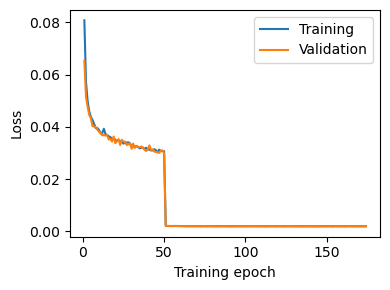

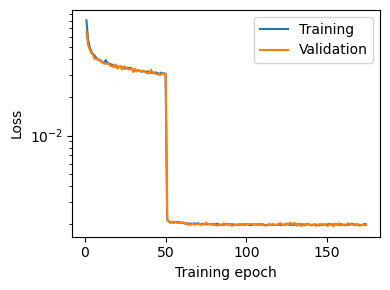

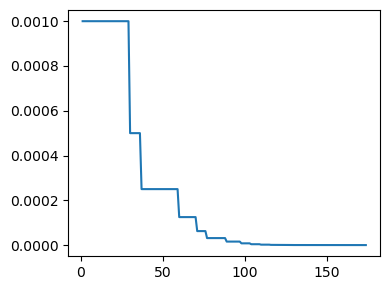

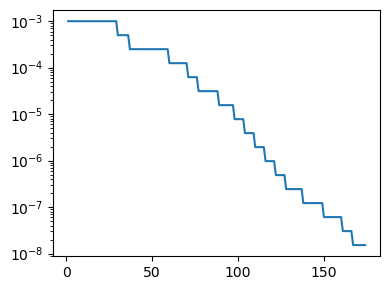

In [12]:
# Plot loss
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), mean_losses)
ax.plot(range(1, n_chk+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss.pdf")

plt.show()
plt.close()

# Plot loss, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), mean_losses)
ax.semilogy(range(1, n_chk+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss_log.pdf")

plt.show()
plt.close()

# Plot learning rate
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs.pdf")

plt.show()
plt.close()

# Plot learning rate, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs_log.pdf")

plt.show()
plt.close()

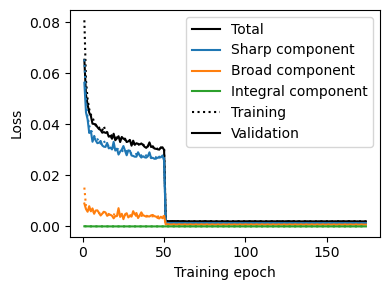

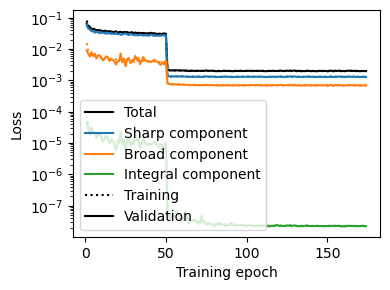

In [13]:
if mean_loss_components is not None:

    # Plot loss components
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    hs = []

    ax.plot(range(1, n_chk+1), mean_losses, f"k:")
    ax.plot(range(1, n_chk+1), mean_val_losses, f"k")
    hs.append(mpl.lines.Line2D([0], [0], color=f"k"))

    for i in range(mean_loss_components.shape[-1]):
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i], f"C{i}:")
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i], f"C{i}")
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle=":"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))

    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")
    
    labels = ["Total"]
    labels.extend(loss_components)
    labels.append("Training")
    labels.append("Validation")

    ax.legend(hs, labels)

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_components.pdf")

    plt.show()
    plt.close()

    # Plot loss components, log
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    hs = []

    ax.plot(range(1, n_chk+1), mean_losses, f"k:")
    ax.plot(range(1, n_chk+1), mean_val_losses, f"k")
    hs.append(mpl.lines.Line2D([0], [0], color=f"k"))

    for i in range(mean_loss_components.shape[-1]):
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i], f"C{i}:")
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i], f"C{i}")
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle=":"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))

    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.legend(hs, labels)

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_components_log.pdf")

    plt.show()
    plt.close()

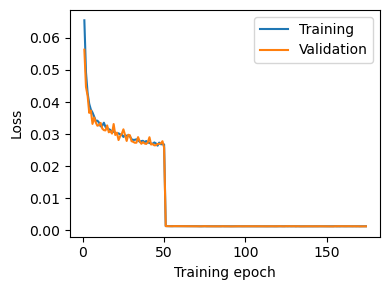

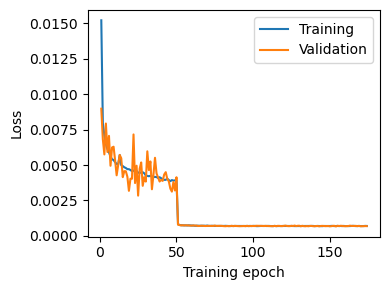

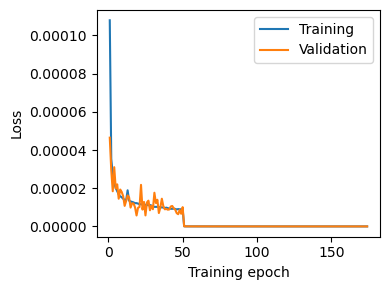

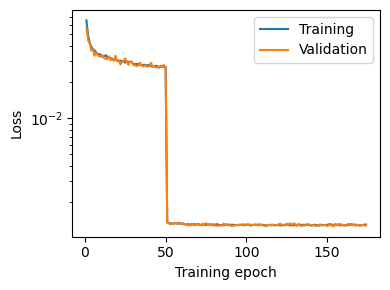

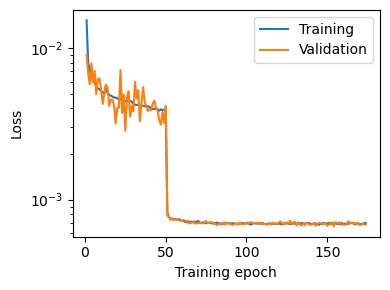

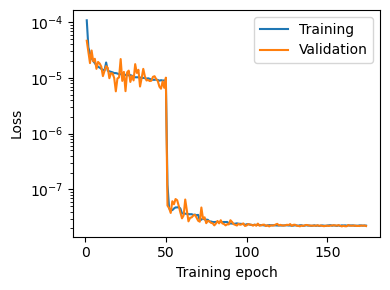

In [14]:
if mean_loss_components is not None:

    for i in range(mean_loss_components.shape[-1]):
        # Plot loss components
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i])
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i])
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

        ax.set_xlabel("Training epoch")
        ax.set_ylabel("Loss")

        ax.legend(["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"loss_component_{i}.pdf")

        plt.show()
        plt.close()
        
    for i in range(mean_loss_components.shape[-1]):
        # Plot loss components
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.semilogy(range(1, n_chk+1), mean_loss_components[:, i])
        ax.semilogy(range(1, n_chk+1), mean_val_loss_components[:, i])
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

        ax.set_xlabel("Training epoch")
        ax.set_ylabel("Loss")

        ax.legend(["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"loss_component_{i}_log.pdf")

        plt.show()
        plt.close()

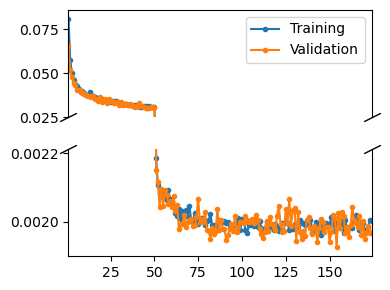

In [15]:
d = 0.5
max_diff = 0.5

mean_losses_dif = np.abs(mean_losses[1:] - mean_losses[:-1])
rel_diffs = mean_losses_dif / mean_losses[:-1]
jumps = np.where(rel_diffs > max_diff)[0]+1

if len(jumps) > 0:

    fig = plt.figure(figsize=(4,3))

    axs = []
    for i in range(len(jumps) + 1):
        axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

        # Plot broken axes markers
        if i > 0:
            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["top"].set_visible(False)

        if i < len(jumps):
            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["bottom"].set_visible(False)
            axs[i].set_xticks([])

        h1 = axs[i].plot(range(1, n_chk+1), mean_losses, ".-")
        h2 = axs[i].plot(range(1, n_chk+1), mean_val_losses, ".-")
        axs[i].set_xlim(1, n_chk)

        if i == 0:
            M = np.max(mean_losses[:jumps[i]])
            M = max(M, np.max(mean_val_losses[:jumps[i]]))
            m = np.min(mean_losses[:jumps[i]])
            m = min(M, np.min(mean_val_losses[:jumps[i]]))

        elif i == len(jumps):
            M = np.max(mean_losses[jumps[i-1]:])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:]))
            m = np.min(mean_losses[jumps[i-1]:])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:]))

        else:
            M = np.max(mean_losses[jumps[i-1]:jumps[i]])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:jumps[i]]))
            m = np.min(mean_losses[jumps[i-1]:jumps[i]])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:jumps[i]]))

        r = M - m

        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_split.pdf")

    plt.show()
    plt.close()

Loss component 0:
Training loss minimum: 1.279e-03, mean over 10 last epochs: 1.298e-03
Validation loss minimum: 1.260e-03, mean over 10 last epochs: 1.289e-03



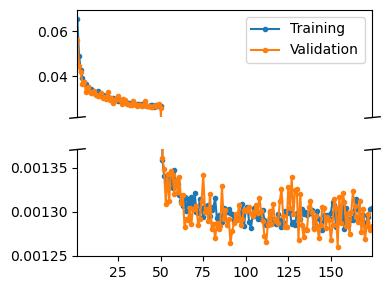

Loss component 1:
Training loss minimum: 6.838e-04, mean over 10 last epochs: 6.963e-04
Validation loss minimum: 6.664e-04, mean over 10 last epochs: 6.922e-04



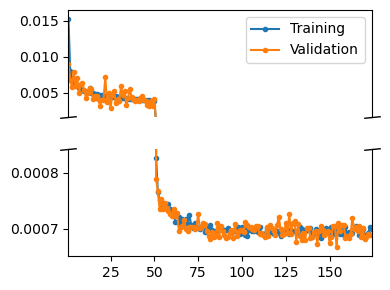

Loss component 2:
Training loss minimum: 2.205e-08, mean over 10 last epochs: 2.249e-08
Validation loss minimum: 2.170e-08, mean over 10 last epochs: 2.230e-08



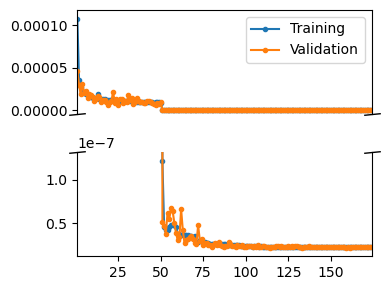

In [16]:
d = 0.1
max_diff = 0.5

if mean_loss_components is not None:

    for k in range(mean_loss_components.shape[-1]):
        
        pp = f"Loss component {k}:\n"
        
        pp += "Training loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_loss_components[:, k]), np.mean(mean_loss_components[-10:, k]))
        pp += "Validation loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_val_loss_components[:, k]), np.mean(mean_val_loss_components[-10:, k]))
        print(pp)
        
        with open(f"{fig_dir}loss_component_{k}_summary.txt", "w") as F:
            F.write(pp)

        diffs = np.abs(mean_loss_components[1:, k] - mean_loss_components[:-1, k])
        rel_diffs = diffs / mean_loss_components[:-1, k]
        jumps = np.where(rel_diffs > max_diff)[0]+1
        
#        jumps = [jumps[-1]]
        jumps = [50]

        if len(jumps) > 0:

            fig = plt.figure(figsize=(4,3))

            axs = []
            for i in range(len(jumps) + 1):
                axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

                # Plot broken axes markers
                if i > 0:
                    axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                    axs[i].spines["top"].set_visible(False)

                if i < len(jumps):
                    axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                    axs[i].spines["bottom"].set_visible(False)
                    axs[i].set_xticks([])

                h1 = axs[i].plot(range(1, n_chk+1), mean_loss_components[:, k], ".-")
                h2 = axs[i].plot(range(1, n_chk+1), mean_val_loss_components[:, k], ".-")
                axs[i].set_xlim(1, n_chk)

                if i == 0:
                    M = np.max(mean_loss_components[:jumps[i], k])
                    M = max(M, np.max(mean_val_loss_components[:jumps[i], k]))
                    m = np.min(mean_loss_components[:jumps[i], k])
                    m = min(M, np.min(mean_val_loss_components[:jumps[i], k]))

                elif i == len(jumps):
                    M = np.max(mean_loss_components[jumps[i-1]:, k])
                    M = max(M, np.max(mean_val_loss_components[jumps[i-1]:, k]))
                    m = np.min(mean_loss_components[jumps[i-1]:, k])
                    m = min(m, np.min(mean_val_loss_components[jumps[i-1]:, k]))

                else:
                    M = np.max(mean_loss_components[jumps[i-1]:jumps[i], k])
                    M = max(M, np.max(mean_val_loss_components[jumps[i-1]:jumps[i], k]))
                    m = np.min(mean_loss_components[jumps[i-1]:jumps[i], k])
                    m = min(m, np.min(mean_val_loss_components[jumps[i-1]:jumps[i], k]))

                r = M - m

                axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

            axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

            fig.tight_layout()

            plt.savefig(fig_dir + f"loss_component_{k}_split.pdf")

            plt.show()
            plt.close()

# Evaluate the model history

In [17]:
def plot_checkpoint(X, y_trg, y_pred, y_std, ys=None, input_factor=0.5, show=True, save=None, anim=False, all_steps=False,
                    c_start=[0., 1., 1.], c_stop=[0., -1., 0.], c2_start=[1., 1., 0.], c2_stop=[0., -1., 0.]):
    
    if y_std is None:
        y_std = [[] for _ in range(X.shape[0])]
    
    n_pts = X.shape[-1]
    
    n = X.shape[1] - 1
    
    colors = [[c0 + (i / n) * c1 for c0, c1 in zip(c_start, c_stop)] for i in range(n+1)]
    
    if ys is not None:
        n2 = ys.shape[0] - 1
        colors2 = [[c0 + (i / n2) * c1 for c0, c1 in zip(c2_start, c2_stop)] for i in range(n2+1)]
    
    for i, (Xi, yi_trg, yi_pred, yi_std) in enumerate(zip(X, y_trg, y_pred, y_std)):
        
        for k in range(yi_pred.shape[0]):
            
            if all_steps or k == yi_pred.shape[0] - 1:

                # Print target vs. pred
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                ax.plot(yi_trg[0], linewidth=1.)
                ax.plot(yi_pred[k], linewidth=1.)

                if len(yi_std) > 0:
                    ax.fill_between(range(n_pts), yi_pred[k] - yi_std[k], yi_pred[k] + yi_std[k], facecolor="C1", alpha=0.3)

                ax.legend(["Ground-truth", "Prediction"])

                fig.tight_layout()
                
                if show:
                    plt.show()

                if save is not None:
                    plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}.pdf")

                plt.close()
        
        if anim:
            
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)
            trg, = ax.plot(range(n_pts), yi_trg[0], lw=1.)
            pred, = ax.plot(range(n_pts), yi_pred[0], lw=1.)
            ax.fill_between(range(n_pts), yi_pred[0] - yi_std[0], yi_pred[0] + yi_std[0], facecolor="C1", alpha=0.3)

            ax.legend(["Ground-truth", f"Prediction {1:02}"])
            
            fig.tight_layout()

            def init():
                ax.set_ylim(-0.1, 1.)
                ax.set_xlim(-1, n_pts)
                return fig,
            
            def update(k):
                ax.collections.clear()
                pred.set_data(range(n_pts), yi_pred[k])
                ax.fill_between(range(n_pts), yi_pred[k] - yi_std[k], yi_pred[k] + yi_std[k], facecolor="C1", alpha=0.3)
                ax.legend(["Ground-truth", f"Prediction {k+1:02}"])
                return fig,
            
            A = anm.FuncAnimation(fig, update, init_func=init, frames=yi_pred.shape[0], interval=250, blit=True)
            
            if save is not None:
                A.save(save + f"sample_{i+1}_pred_anim.gif", dpi=300)
            
            plt.close()
        
        if ys is not None:
            
            for k in range(ys.shape[2]):
                # Print target vs. all preds
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                h1 = ax.plot(yi_trg[0], linewidth=1.)

                for c, yi in zip(colors2, ys[:, i, k, :]):
                    ax.plot(yi, linewidth=1., color=c)

                h2 = ax.plot(yi_pred[k], linewidth=1., color="k")

                ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"], loc=0)

                fig.tight_layout()
                
                if show:
                    plt.show()

                if save is not None:
                    plt.savefig(save + f"sample_{i+1}_all_preds_step_{k+1}.pdf")

                plt.close()
            
            for j in range(ys.shape[0]):
                
                for k in range(ys.shape[2]):

                    # Print target vs. all preds
                    fig = plt.figure(figsize=(4,3))
                    ax = fig.add_subplot(1,1,1)

                    h1 = ax.plot(yi_trg[0], linewidth=1.)

                    ax.plot(ys[j, i, k, :], linewidth=1., color=colors2[j])

                    h2 = ax.plot(yi_pred[k], linewidth=1., color="k")

                    ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"])

                    fig.tight_layout()
                    
                    if show:
                        plt.show()

                    if save is not None:
                        plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}_model_{j+1}.pdf")

                    plt.close()
        
        # Print input and target
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        for x, c in zip(Xi[:, 0, :], colors):
            ax.plot(x / np.max(Xi[:, 0, :]), linewidth=1., color=c)
        ax.plot(yi_trg[0] / np.max(yi_trg[0]) * input_factor, "r", linewidth=1.)
        
        fig.tight_layout()
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_input.pdf")
            
        plt.close()
    
    return

In [18]:
if eval_history:

    fdir = fig_dir + "eval_history/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        if (sel_history == "all" or i in sel_history) and os.path.exists(in_dir + f"checkpoint_{i+1}_in.npy"):

            print(f"Checkpoint {i+1}...")

            d = fdir + f"checkpoint_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)

            if overwrite or not os.path.exists(d + "sample_1_input.pdf"):

                X = np.load(in_dir + f"checkpoint_{i+1}_in.npy")
                y_trg = np.load(in_dir + f"checkpoint_{i+1}_trg.npy")
                y_pred = np.load(in_dir + f"checkpoint_{i+1}_pred.npy")
                y_std = np.load(in_dir + f"checkpoint_{i+1}_std.npy")

                plot_checkpoint(X, y_trg, y_pred, y_std, anim=True, all_steps=False, show=False, save=d)

print("All done!")

Checkpoint 1...
Checkpoint 10...
Checkpoint 20...
Checkpoint 30...
Checkpoint 40...
Checkpoint 50...
Checkpoint 60...
Checkpoint 70...
Checkpoint 80...
Checkpoint 90...
Checkpoint 100...
Checkpoint 110...
Checkpoint 120...
Checkpoint 130...
Checkpoint 140...
Checkpoint 150...
Checkpoint 160...
Checkpoint 170...
All done!


# Load model and generate dataset

In [19]:
if eval_evolution or eval_custom or eval_sparse or eval_noise or eval_exp or eval_new_exp or vis_filters or eval_broad_iso or eval_broad_mas:

    net = model.ConvLSTMEnsemble(**model_pars)
    net.eval()
    
    if eval_evolution or eval_custom or eval_sparse or eval_noise or vis_filters:

        X = []
        y = []

        for i in range(n_samples):
            Xi, _, yi = dataset.__getitem__(0)
            X.append(Xi.unsqueeze(0))
            y.append(yi.unsqueeze(0))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)

In [20]:
def print_filter(X, filt, f_inds, max_smpl=-1, encode_mas=False, show=True, save=None, xl=[0., 1.], yl=[0., 1.], sig=True):
    
    c0 = np.array([0., 1., 1.])
    dc = np.array([0.,-1., 0.])

    n_filt = len(f_inds)
    n_smpl = X.shape[0]
    if max_smpl > 0:
        n_smpl = min(n_smpl, max_smpl)
    n_pts = X.shape[-1]
    n_row = int(np.sqrt(n_filt))
    n_col = int(n_filt / n_row)
    n_col += 1 if (n_filt / n_row) > int(n_filt / n_row) else 0
    
    for sample in range(n_smpl):
        
        # Filter as color

        fig = plt.figure(figsize=(5*n_col,3*n_row))
        axs = []
        for row in range(n_row):
            for col in range(n_col):
                axs.append(fig.add_subplot(n_row,n_col,(row * n_col) + col + 1))

        if sig:
            for i, f_ind in enumerate(f_inds):
                
                if i % n_col != 0:
                    axs[i].set_yticks([])
                
                if int(i / n_row + 1) < n_row:
                    axs[i].set_xticks([])
                    
                vmin = torch.min(filt[sample, f_ind])
                vmax = torch.max(filt[sample, f_ind])
                for xi in X[sample]:
                    
                    cb = axs[i].scatter(range(n_pts), xi, s=5, c=filt[sample, f_ind],
                                        cmap="Blues", marker=".", vmin=vmin, vmax=vmax)

                fig.colorbar(cb, ax=axs[i])

        else:
            for i, f_ind in enumerate(f_inds):
                
                vmin = torch.min(filt[sample, f_ind])
                vmax = torch.max(filt[sample, f_ind])
                for xi in X[sample]:
                    cb = axs[i].scatter(range(n_pts), xi, s=5, c=filt[sample, f_ind],
                                        cmap="jet", marker=".", vmin=vmin, vmax=vmax)
                    
                fig.colorbar(cb, ax=axs[i])
                        
        for i in range(n_filt):
            axs[i].set_xlim(xl)
            axs[i].set_ylim(yl)
            
        fig.tight_layout()
        
        if show:
            plt.show()
        
        if save is not None:
            plt.savefig(save + f"_sample_{sample+1}.pdf")
            
        plt.close()
        
        # Filter as spectrum
        
        fig = plt.figure(figsize=(5*n_col,3*n_row))
        axs = []
        for row in range(n_row):
            for col in range(n_col):
                axs.append(fig.add_subplot(n_row,n_col,(row * n_col) + col + 1))

        for i, f_ind in enumerate(f_inds):
            
            hs = []

            for k, xi in enumerate(X[sample]):
                h = axs[i].plot(range(n_pts), xi, c=c0 + (k / (X[sample].shape[0]-1) * dc))
            hs.append(h[0])
            
            h = axs[i].plot(range(n_pts), filt[sample, f_ind], "C1")
            hs.append(h[0])
                        
        for i in range(n_filt):
            axs[i].legend(hs, ["Input", "Output"])
            
        fig.tight_layout()
        
        if show:
            plt.show()
        
        if save is not None:
            plt.savefig(save + f"_sample_{sample+1}_filt.pdf")
            
        plt.close()
    
    return

In [21]:
def get_filt_inds(all_filt, max_filt=-1):
    
    filt = torch.cat(all_filt, dim=0)
    
    df = torch.max(filt[:, :, 50:-50], axis=-1)[0] - torch.min(filt[:, :, 50:-50], axis=-1)[0]
    df = torch.max(df, dim=0)[0]
    
    f_inds = torch.argsort(df, descending=True)
    
    return f_inds[:max_filt]

In [22]:
if vis_filters:
    fdir = fig_dir + "vis_filters/"
    
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
    
    if not os.path.exists(fdir):
        os.mkdir(fdir)
        
    xl = [-1, X.shape[-1]]
    dy = (torch.max(X[:, :, 0, :]) - torch.min(X[:, :, 0, :])) * 0.05
    yl = [torch.min(X[:, :, 0, :]) - dy, torch.max(X[:, :, 0, :]) + dy]

    for ind_model, model in enumerate(net.models):
        
        mdir = fdir + f"model_{ind_model+1}/"
    
        if not os.path.exists(mdir):
            os.mkdir(mdir)

        print(f"Model {ind_model+1}/{len(net.models)}...")
        X_vis = net.models[ind_model]._batch_input(X[:, :, :1, :])
        
        for ind_layer in range(len(net.models[ind_model].cell_list)):
            
            ldir = mdir + f"layer_{ind_layer+1}/"
    
            if not os.path.exists(ldir):
                os.mkdir(ldir)
            
            # Initialize state and batch input
            hidden_state = net.models[ind_model]._init_hidden(batch_size=X.shape[0], image_size=X.shape[-1])
            cur_layer_input = net.models[ind_model]._batch_input(X)

            # Run previous layers
            if ind_layer > 0:
                for prev_layer in range(ind_layer):
                    h, c = hidden_state[prev_layer]
                    output_inner = []
                    for t in range(cur_layer_input.shape[1]):
                        h, c = net.models[ind_model].cell_list[prev_layer].forward(cur_layer_input[:, t, :, :], cur_state=[h, c])
                        output_inner.append(h)
                    cur_layer_input = torch.stack(output_inner, dim=1)

            print(f"  Cell {ind_layer+1}/{len(net.models[ind_model].cell_list)}...")
            h, c = hidden_state[ind_layer]
            
            all_i = []
            all_f = []
            all_o = []
            all_g = []
            all_h = []
            all_c = []

            for t in range(cur_layer_input.shape[1]):
                i, f, o, g, h, c = net.models[ind_model].cell_list[ind_layer].analyze(cur_layer_input[:, t], [h, c])
                
                all_i.append(i.detach().clone())
                all_f.append(f.detach().clone())
                all_g.append(g.detach().clone())
                all_h.append(h.detach().clone())
                all_c.append(c.detach().clone())
                
                if not model_pars["independent"]:
                    all_o.append(o.detach().clone())
                else:
                    all_o.append(None)
            
            for t, (i, f, o, g, h, c) in enumerate(zip(all_i, all_f, all_o, all_g, all_h, all_c)):
                
                print(f"    State {t+1}/{cur_layer_input.shape[1]}...")

                if overwrite or f"i_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing input gate...")
                    i_inds = get_filt_inds(all_i, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), i.detach().clone(), i_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}i_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"f_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing forget gate...")
                    f_inds = get_filt_inds(all_f, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), f.detach().clone(), f_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}f_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if not model_pars["independent"] and (overwrite or f"o_{t+1}_sample_1.pdf" not in os.listdir(ldir)):
                    print("      Printing output gate...")
                    o_inds = get_filt_inds(all_o, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), o.detach().clone(), o_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}o_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"g_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing cell state update...")
                    g_inds = get_filt_inds(all_g, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), g.detach().clone(), g_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}g_{t+1}", xl=xl, yl=yl, sig=False)
                    
                if overwrite or f"h_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing LSTM output...")
                    h_inds = get_filt_inds(all_h, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), h.detach().clone(), h_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}h_{t+1}", xl=xl, yl=yl, sig=False)
                    
                if overwrite or f"c_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing cell state...")
                    c_inds = get_filt_inds(all_c, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), c.detach().clone(), c_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}c_{t+1}", xl=xl, yl=yl, sig=False)

print("All done!")

All done!


In [23]:
if eval_evolution:

    fdir = fig_dir + "eval_evolution/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        if (sel_chk == "all" or i in sel_chk) and os.path.exists(in_dir + f"checkpoint_{i+1}_network"):

            print(f"Checkpoint {i+1}/{n_chk}...")

            d = fdir + f"checkpoint_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)
            
            if overwrite or not os.path.exists(d + "sample_1_input.pdf"):

                print("  Loading model...")
                net.load_state_dict(torch.load(in_dir + f"checkpoint_{i+1}_network", map_location=torch.device("cpu")))
                net.eval()

                print("  Performing predictions...")
                y_pred, y_std, ys = net(X)
                y_pred = y_pred.detach().numpy()
                y_std = y_std.detach().numpy()
                ys = ys.detach().numpy()

                print("  Plotting data...")
                plot_checkpoint(X.numpy(), y.numpy(), y_pred, y_std, anim=True, all_steps=False, show=False, save=d)
        
print("All done!")

Checkpoint 1/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 10/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 20/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 30/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 40/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 50/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 60/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 70/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 80/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 90/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 100/174...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 110/174...
  Loading model...
  

In [24]:
if eval_custom:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
    
    fdir = fig_dir + "eval_custom/"
    
    if not os.path.exists(fdir):
        os.mkdir(fdir)

    # Build custom isotropic spectrum
    shifts = np.array([8., 5., 3., 2.])
    lw1 = np.array([0.02, 0.05, 0.03, 0.01]) * 0.05
    lw2 = np.array([4., 7., 4.6, 10.]) * 0.05

    td = 128
    Fs = 10
    tmax = td/Fs
    t2 = np.arange(0, td, 1) / Fs

    fids = np.zeros((len(shifts), len(t2)), dtype=complex)

    for i, (s, l1, l2) in enumerate(zip(shifts, lw1, lw2)):
        fids[i] = np.exp(s * t2 * 2 * np.pi * 1j) * np.exp(-t2 ** 2 * l1 ** 2) * np.exp(-t2 ** 2 * l2 ** 2)
        fids[i, 0] /= 2

    specs = np.real(np.fft.fft(fids, axis=1))
    specs /= specs.shape[0]

    specs = np.pad(specs, ((0, 0), (50, len(dataset.t) - len(t2) - 50)))

    # Add square
    add = np.zeros((1, len(dataset.t)))
    add[0, 125:140] = 2.
    specs = np.concatenate((specs, add), axis=0)

    # Add triangle
    add = np.zeros((1, len(dataset.t)))
    add[0, 155:165] = np.linspace(0.5, 5., num=10)
    specs0 = np.concatenate((specs, add), axis=0)

    iso0 = np.expand_dims(np.sum(specs0, axis=0), 0) * 10
    
    Xs_custom = []
    ys_custom = []
    
    for i in range(n_custom):
        
        # Generate MAS spectra
        wr, ls, gs, ss, ps = dataset.gen_mas_params(specs.shape[0])

        brd_specs = dataset.mas_broaden(specs, wr, ls, gs, ss, ps)
        
        iso, specs, brd_specs = dataset.normalize_spectra(np.copy(iso0), np.copy(specs0), brd_specs)

        X_custom, _, y_custom = dataset.finalize_spectra(iso, specs, brd_specs, wr)

        Xs_custom.append(X_custom.unsqueeze(0))
        ys_custom.append(y_custom.unsqueeze(0))
        
    X_custom = torch.cat(Xs_custom, dim=0)
    y_custom = torch.cat(ys_custom, dim=0)
    
    for scale in x_scales:
        
        fdir = fig_dir + f"eval_custom/scale_{scale}/"
        
        if not os.path.exists(fdir):
            os.mkdir(fdir)
        
            X_custom[:, :, 0] /= torch.max(X_custom[:, :, 0]) / scale

            # Perform predictions
            y_pred, y_std, ys = net(X_custom)
            y_pred = y_pred.detach().numpy()
            y_std = y_std.detach().numpy()

            plot_checkpoint(X_custom.numpy(), y_custom.numpy(), y_pred, y_std, anim=True, all_steps=False, show=False, save=fdir)

print("All done!")

All done!


In [25]:
if eval_broad_iso:
    
    for broad_iso_factor in broad_iso_factors:

        # Update dataset
        data_pars2 = copy.deepcopy(data_pars)

        for i in range(len(data_pars2["lw"])):
            data_pars2["lw"][i] *= broad_iso_factor

        dataset2 = data.PIPDataset(**data_pars2)

        X = []
        y = []

        for i in range(n_samples):
            Xi, _, yi = dataset2.__getitem__(0)
            X.append(Xi.unsqueeze(0))
            y.append(yi.unsqueeze(0))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)

        # Load best model
        net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

        fdir = fig_dir + f"eval_broad_iso_factor_{broad_iso_factor}/"

        if not os.path.exists(fdir):
            os.mkdir(fdir)

        y_pred, y_std, ys = net(X)

        plot_checkpoint(X.numpy(), y.numpy(), y_pred.detach().numpy(), y_std.detach().numpy(), anim=True, all_steps=False, show=False, save=fdir)

print("All done!")

All done!


In [26]:
if eval_broad_mas:
    
    for broad_mas_factor in broad_mas_factors:

        # Update dataset
        data_pars2 = copy.deepcopy(data_pars)

        for i in range(len(data_pars2["mas_g_range"])):
            data_pars2["mas_g_range"][i] *= broad_mas_factor

        for i in range(len(data_pars2["mas_l_range"])):
            data_pars2["mas_l_range"][i] *= broad_mas_factor

        dataset2 = data.PIPDataset(**data_pars2)

        X = []
        y = []

        for i in range(n_samples):
            Xi, _, yi = dataset2.__getitem__(0)
            X.append(Xi.unsqueeze(0))
            y.append(yi.unsqueeze(0))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)

        # Load best model
        net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

        fdir = fig_dir + f"eval_broad_mas_factor_{broad_mas_factor}/"

        if not os.path.exists(fdir):
            os.mkdir(fdir)

        y_pred, y_std, ys = net(X)

        plot_checkpoint(X.numpy(), y.numpy(), y_pred.detach().numpy(), y_std.detach().numpy(), anim=True, all_steps=False, show=False, save=fdir)

print("All done!")

All done!


In [27]:
if eval_sparse:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_sparse/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    # Lower MAS inputs
    print("Lower MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"lower_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, :i])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_pred, y_std, anim=True, all_steps=False, show=False, save=d)
    
    # Higher MAS inputs
    print("Higher MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"higher_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, -i:])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_pred, y_std, anim=True, all_steps=False, show=False, save=d)
        
print("All done!")

All done!


In [28]:
if eval_noise:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_noise/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    for noise in noise_levels:
        
        break
        
        print(f"Noise level {noise:.0e}...")
        
        d = fdir + f"noise_level_{noise:.0e}/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        # Generate noisy data
        X2 = X.clone() + (torch.randn(X.shape) * noise)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_pred, y_std, anim=True, all_steps=False, show=False, save=d)
        
        print("Normalizing noisy spectra...")
        
        d = fdir + f"noise_level_{noise:.0e}_norm/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        vals_min, _ = torch.min(X2[:, :, 0], dim=-1)
        vals_min = torch.unsqueeze(vals_min, -1)
        X2[:, :, 0] -= vals_min
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_pred, y_std, anim=True, all_steps=False, show=False, save=d)
    
print("All done!")

All done!


# Evaluate experimental data

In [29]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"

    with open(fr, "rb") as F:
        dr = np.fromfile(F, np.int32).astype(float)

    with open(fi, "rb") as F:
        di = np.fromfile(F, np.int32).astype(float)

    with open(f"{d}acqus", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$MASR"):
            wr = int(l.split("=")[1].strip())
        if l.startswith("##$TD="):
            TD = int(l.split("=")[1].strip())
        if l.startswith("##$SW_h="):
            SW = float(l.split("=")[1].strip())

    with open(f"{pd}procs", "r") as F:
        lines = F.read().split("\n")

    for l in lines:
        if l.startswith("##$SI="):
            n_pts = int(l.split("=")[1].strip())

        if l.startswith("##$OFFSET="):
            offset = float(l.split("=")[1].strip())

        if l.startswith("##$SF="):
            SF = float(l.split("=")[1].strip())
            
    AQ = TD / (2 * SW)

    hz = offset * SF - np.arange(n_pts) / (2 * AQ * n_pts / TD)
    
    ppm = hz / SF

    return dr, di, wr, ppm, hz

In [30]:
def extract_exp_topspin(in_dir, compound):
    
    d0 = f"{in_dir}{compound}/"
    
    ws = []
    X_real = []
    X_imag = []
    
    for d in os.listdir(d0):
        if d.isnumeric():
            Xr, Xi, wr, ppm, hz = load_topspin_spectrum(f"{d0}{d}/")
            X_real.append(Xr)
            X_imag.append(Xi)
            ws.append(wr)
    
    sorted_inds = np.argsort(ws)
    
    sorted_ws = np.array([ws[i] for i in sorted_inds])
    
    sorted_X_real = np.array([X_real[i] for i in sorted_inds])
    sorted_X_imag = np.array([X_imag[i] for i in sorted_inds])
    
    return ppm, sorted_ws, sorted_X_real, sorted_X_imag

In [31]:
def extract_fit_model(in_dir, compound, parts, res):
    
    if compound == "mdma":
        c = compound
    else:
        c = compound[:3]
    
    ys_part_means = []
    ys_part_stds = []
    ys_ppms = []
    
    if len(parts) == 0 or len(res) == 0:
        return [], [], []
    
    for p, n in zip(parts, res):
        
        
        d = f"{in_dir}{compound}_{n}/"
        
        if not os.path.exists(d):
            return [], [], []
    
        ys_part = []

        i_guess = 1
        while os.path.exists(f"{d}{c}_{p}_guess_r{i_guess}.mat"):

            m = scipy.io.loadmat(f"{d}{c}_{p}_guess_r{i_guess}.mat")

            ys_part.append(m["x"][:-3])
            ppm = m["ppm"][0, m["range"][0]]
            
            i_guess += 1
        
        if len(ys_ppms) > 0:
            already_ppms = np.concatenate(ys_ppms, axis=0)
            inds = np.where(np.logical_or(ppm < np.min(already_ppms), ppm > np.max(already_ppms)))[0]
        else:
            inds = range(len(ppm))
        
        ys_ppms.append(ppm[inds])
        ys_part = np.concatenate(ys_part, axis=1)
        ys_part_means.append(np.mean(ys_part, axis=1)[inds])
        ys_part_stds.append(np.std(ys_part, axis=1)[inds])
    
    ys_ppms = np.concatenate(ys_ppms, axis=0)
    ys_part_means = np.concatenate(ys_part_means, axis=0)
    ys_part_stds = np.concatenate(ys_part_stds, axis=0)
    
    return ys_ppms, ys_part_means, ys_part_stds

In [32]:
def make_input(X, ws, data_pars, Xi=None, x_max=0.25):
    
    inds = np.argsort(ws)
    X_torch = torch.Tensor(X[inds])
    X_torch = torch.unsqueeze(X_torch, dim=0)
    X_torch = torch.unsqueeze(X_torch, dim=2)
    
    M = torch.max(X_torch)
    
    X_torch /= M
    X_torch *= x_max
    
    if data_pars["encode_w"]:
        W = torch.Tensor(ws[inds])
        W = torch.unsqueeze(W, dim=0)
        W = torch.unsqueeze(W, dim=2)
        W = torch.unsqueeze(W, dim=3)
        W = W.repeat(1, 1, 1, X_torch.shape[-1])
        
        if data_pars["norm_wr"]:
            W -= data_pars["mas_w_range"][0]
            W /= data_pars["mas_w_range"][1] - data_pars["mas_w_range"][0]
    
    if Xi is not None:
        X_imag = torch.Tensor(Xi[inds])
        X_imag = torch.unsqueeze(X_imag, dim=0)
        X_imag = torch.unsqueeze(X_imag, dim=2)
        X_imag /= M
        X_imag *= x_max
        
        X_torch = torch.cat([X_torch, X_imag, W], dim=2)
    
    else:
        X_torch = torch.cat([X_torch, W], dim=2)
    
    return X_torch, ws[inds]

In [33]:
def plot_exp_vs_pred(ppm, X, y_pred, y_std, ppm_trg, y_trg_avg, y_trg_std, show=True, save=None, x_offset=0.,
                     y0_pred=0., y0_trg=0., y_pred_scale=0.5, y_trg_scale=0.5, reverse_trg=False, xl=[20., -5.], c0=[0., 1., 1.], dc = [0., -1., 0.]):
    
    # Initialize figure
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    n = X.shape[0]
    if n == 1:
        colors = [[ci + dci for ci, dci in zip(c0, dc)]]
        
    else:
        colors = [[ci + (dci * i / (n-1)) for ci, dci in zip(c0, dc)] for i in range(n)]
    
    try:
        X2 = np.copy(X.numpy())
    except:
        X2 = np.copy(X)
    
    X2 /= np.max(X2)
    
    try:
        y_pred2 = y_pred.numpy()
        y_std2 = y_std.numpy()
    except:
        y_pred2 = y_pred
        y_std2 = y_std
    
    factor = np.max(y_pred2) / y_pred_scale
    y_pred2 /= factor
    y_std2 /= factor
    
    if len(y_trg_avg) > 0:
        factor = np.max(y_trg_avg) / y_trg_scale
        y_trg_avg2 = y_trg_avg / factor
        y_trg_std2 = y_trg_std / factor
    
    
    # Plot inputs
    for i, (c, x) in enumerate(zip(colors, X2)):
        ax.plot(ppm, x + i * x_offset, color=c, linewidth=1)
    
    # Plot predictions
    ax.plot(ppm, y_pred2 + y0_pred, "r", linewidth=1)
    ax.fill_between(ppm, y_pred2 - y_std2 + y0_pred, y_pred2 + y_std2 + y0_pred, color="r", alpha=0.3)
    
    if len(y_trg_avg) > 0:
        # Plot target
        if reverse_trg:
            ax.plot(ppm_trg, -y_trg_avg2 + y0_trg, "k", linewidth=1)
            ax.fill_between(ppm_trg, -y_trg_avg2 - y_trg_std2 + y0_trg, -y_trg_avg2 + y_trg_std2 + y0_trg, color="k", alpha=0.3)

        else:
            ax.plot(ppm_trg, y_trg_avg2 + y0_trg, "k", linewidth=1)
            ax.fill_between(ppm_trg, y_trg_av2g - y_trg_std2 + y0_trg, y_trg_avg2 + y_trg_std2 + y0_trg, color="k", alpha=0.3)

    # Update axis
    ax.set_xlim(xl)
    ax.set_yticks([])
    ax.set_xlabel("Chemical shift [ppm]")
    
    # Cleanup layout
    fig.tight_layout()
    
    # Save figure
    if save:
        plt.savefig(save)
    
    # Show figure
    if show:
        plt.show()
        
    # Close figure
    plt.close()
    
    return

In [34]:
def extract_linewidth(x, y, r, nfit=3):
    
    inds = np.where(np.logical_and(x > r[0], x < r[1]))[0]

    dx = np.mean(x[1:] - x[:-1])
    
    top = np.max(y[inds])
    
    i0 = np.argmax(y[inds])
    
    xr = None
    xl = None
    
    for i, j in zip(inds[:-1], inds[1:]):
        if y[i] > top / 2 and y[j] < top / 2:
            
            dy = y[j] - y[i]
            
            dy2 = (top / 2) - y[i]
            
            xr = x[i] + dx * dy2 / dy
            
        
        if y[i] < top / 2 and y[j] > top / 2:
            
            dy = y[j] - y[i]
            
            dy2 = (top / 2) - y[i]
            
            xl = x[i] + dx * dy2 / dy
    
    if xl is None:
        xl = x[inds[0]]
    if xr is None:
        xr = x[inds[-1]]
    
    return abs(xl - xr), x[inds[i0]]

In [35]:
def plot_lw(all_lws_fit, all_lws_net, all_pks_fit, all_pks_net, compounds, save):
    
    fig = plt.figure(figsize=(7,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net, s=5)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net, s=5)

    ax1.set_xlabel("Fitted linewidth [ppm]")
    ax1.set_ylabel("PIPNet linewidth [ppm]")
    ax2.set_xlabel("Fitted peak [ppm]")
    ax2.set_ylabel("PIPNet peak [ppm]")

    ax2.legend(compounds)

    fig.tight_layout()

    plt.savefig(f"{save}_preds.pdf")
    plt.close()

    fig = plt.figure(figsize=(7,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net - lws_fit, s=5)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net - pks_fit, s=5)

    ax1.set_xlabel("Fitted linewidth [ppm]")
    ax1.set_ylabel("linewidth difference [ppm]")
    ax2.set_xlabel("Fitted peak [ppm]")
    ax2.set_ylabel("peak difference [ppm]")

    lw_mae = np.mean(np.abs(np.concatenate(all_lws_fit) - np.concatenate(all_lws_net)))
    pk_mae = np.mean(np.abs(np.concatenate(all_pks_fit) - np.concatenate(all_pks_net)))

    ax1.title.set_text(f"MAE = {lw_mae:.2f} ppm")
    ax2.title.set_text(f"MAE = {pk_mae:.2f} ppm")

    ax2.legend(compounds)

    fig.tight_layout()

    plt.savefig(f"{save}_preds_diff.pdf")
    plt.close()
    
    return

In [36]:
def compare_integrals(ppm, X, y, regions):
    
    X_int = []
    y_int = []
    
    for r1, r2 in regions:
        p1 = min(max(1, np.argmin(np.abs(ppm - r1))), len(ppm) - 2)
        p2 = min(max(1, np.argmin(np.abs(ppm - r2))), len(ppm) - 2)
        
        if p1 > p2:
            tmp = p1
            p1 = p2
            p2 = tmp
        
        X_int.append(np.sum(X[p1:p2]))
        y_int.append(np.sum(y[p1:p2]))
        
    X_int = np.array(X_int) / np.sum(X_int)
    y_int = np.array(y_int) / np.sum(y_int)
    
    return X_int, y_int

In [37]:
def plot_integrals(all_X_int, all_y_int, compounds, int_regions, w=0.2, label_h=0.1, show=True, save=None):
    
    # Compound separations
    sep = []
    mid = []
    labels = []
    bounds = []
    i = 0
    for k in compounds:
        if k in int_regions:
            l = len(int_regions[k])
            labels.append(k)
            sep.append(i+l - 0.5)
            mid.append(i + (l / 2) - 0.5)
            i += l
            bounds.append([r[1] for r in int_regions[k][:-1]])
    sep = sep[:-1]
    
    err_avg = []
    err_std = []
    for xint, yint in zip(all_X_int, all_y_int):
        err_avg.append(np.mean(np.abs(xint-yint) / xint*100))
        err_std.append(np.std(np.abs(xint-yint) / xint*100))
    
    x = np.array(range(i))
    
    xint = np.concatenate(all_X_int)
    yint = np.concatenate(all_y_int)
    
    M = max(np.max(xint), np.max(yint)) * 1.1
    
    fig = plt.figure(figsize=(i*0.4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.bar(x-(w/2), xint, width=w)
    ax.bar(x+(w/2), yint, width=w)
    
    ax.legend(["100 kHz MAS", "PIPNet"], bbox_to_anchor=(0.,0.95), loc="upper left")
    
    for s in sep:
        ax.plot([s, s], [0., M], "k")
    
    lx = 0.5
    for b in bounds:
        for bi in b:
            ax.plot([lx, lx], [0, label_h], "k:")
            ax.text(lx, label_h, f" {bi} ppm", rotation=90, ha="center", va="bottom", size=8)
            lx += 1
        lx += 1
    
    for em, es, m in zip(err_avg, err_std, mid):
        ax.text(m, M*0.99, f"{em:.0f}±{es:.0f}% error", ha="center", va="top", size=8)
    
    ax.set_xticks(mid)
    ax.set_xticklabels(labels)
    
    ax.set_ylabel("Relative integral")
    
    ax.set_ylim(0., M)
    ax.set_xlim(-0.5, i-0.5)
    
    if save is not None:
        plt.savefig(save)
    
    if show:
        plt.show()
    
    plt.close()
    
    return

In [38]:
if eval_exp:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
        
    for xscale in x_scales:
        
        all_lws_fit = []
        all_pks_fit = []
        
        sel_all_lws_net = []
        sel_all_pks_net = []
        opt_all_lws_net = []
        opt_all_pks_net = []
        all_all_lws_net = []
        all_all_pks_net = []
        low_all_lws_net = []
        low_all_pks_net = []
        high_all_lws_net = []
        high_all_pks_net = []
        rand_all_lws_net = []
        rand_all_pks_net = []
        
        fdir = fig_dir + f"eval_exp_scale_{xscale}/"
        if not os.path.exists(fdir):
            os.mkdir(fdir)
        
        for compound in exp_compounds:
            r = exp_range[compound]
            print(compound)
            ys_ppms, ys_part_means, ys_part_stds = extract_fit_model(iso_dir, compound,
                                                                     exp_parts[compound], exp_res[compound])
            ppm, ws, X_real, X_imag = extract_exp_topspin(exp_dir, compound)

            if len(ys_part_means) > 0:
                ymax = np.max(ys_part_means)
                ys_part_means /= ymax / 0.5
                ys_part_stds /= ymax / 0.5

            ppm = ppm[r[0]:r[1]]
            X_real = X_real[:, r[0]:r[1]]
            X_imag = X_imag[:, r[0]:r[1]]
    
            normalization = np.sum(X_real, axis=1)[:, np.newaxis]
            X_real /= normalization
            X_imag /= normalization

            if data_pars["encode_imag"]:
                X_torch, ws = make_input(X_real, ws, data_pars, Xi=X_imag)
            else:
                X_torch, ws = make_input(X_real, ws, data_pars)
            
            lws_fit = []
            pks_fit = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ys_ppms, ys_part_means, p)

                lws_fit.append(lw)
                pks_fit.append(pk)
            
            all_lws_fit.append(np.array(lws_fit))
            all_pks_fit.append(np.array(pks_fit))

            # Selected rates
            if evals["sel"]:
                
                print("  Predictions on selected MAS rates...")

                w_inds = []
                for w in sel_wrs:
                    w_inds.append(np.argmin(np.abs(ws - w)))

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_sel_w_pred_{i+1}.pdf")
                
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_sel_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                sel_all_lws_net.append(np.array(lws_net))
                sel_all_pks_net.append(np.array(pks_net))
                
            # Optimized rates
            if evals["opt"]:
                
                print("  Predictions on optimal MAS rates...")
                
                opt_wrs = np.linspace(opt_range[0], opt_range[1], num=data_pars["nw"])
                
                w_inds = []
                for w in opt_wrs:
                    w_inds.append(np.argmin(np.abs(ws - w)))
                w_inds = np.unique(w_inds)

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_opt_w_pred_{i+1}.pdf")
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_opt_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                opt_all_lws_net.append(np.array(lws_net))
                opt_all_pks_net.append(np.array(pks_net))
                    
            # All rates
            if evals["all"]:
                
                print("  Predictions on all MAS rates...")
                
                w_inds = np.argsort(ws)

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5

                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_all_w_pred_{i+1}.pdf") 
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_all_w_pred_final.pdf") 
                
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)
                
                all_all_lws_net.append(np.array(lws_net))
                all_all_pks_net.append(np.array(pks_net))
                
            # Lowest rates
            if evals["low"]:
                
                print("  Predictions on lowest MAS rates...")

                X_net = X_torch[:, :data_pars["nw"]]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_low_w_pred_{i+1}.pdf")
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_low_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                low_all_lws_net.append(np.array(lws_net))
                low_all_pks_net.append(np.array(pks_net))
                
            # Highest rates
            if evals["high"]:
                
                print("  Predictions on highest MAS rates...")

                X_net = X_torch[:, -data_pars["nw"]:]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_high_w_pred_{i+1}.pdf")
                
                
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_high_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                high_all_lws_net.append(np.array(lws_net))
                high_all_pks_net.append(np.array(pks_net))

            # Randomly selected rates
            if evals["rand"] > 0:
                
                print("  Predictions on randomly selected MAS rates...")
                
                all_ys = []
                for k in range(evals["rand"]):
                    
                    print(f"    Selection {k+1}/{evals['rand']}...")
                    
                    w_inds = np.sort(np.random.choice(range(X.shape[0]), size=data_pars["nw"], replace=False))

                    X_net = X_torch[:, w_inds]
                    X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                    y_pred, y_std, ys = net(X_net)

                    y_pred = y_pred.detach().numpy()[0]
                    y_std = y_std.detach().numpy()[0]

                    ymax = np.max(y_pred)
                    y_pred /= ymax / 0.5

                    y_std /= ymax / 0.5
                    
                    all_ys.append(ys.detach().numpy()[:, 0])

                    for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                        plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                         y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                         save=f"{fdir}{compound}_rand_w_{k+1}_pred_{i+1}.pdf")
                    
                    plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_rand_w_{k+1}_pred_final.pdf")
                
                ys = np.concatenate(all_ys, axis=0)
                y_pred = np.mean(ys, axis=0)
                y_std = np.std(ys, axis=0)
                
                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_rands_pred_{i+1}.pdf")
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_rands_pred_final.pdf")
                
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                rand_all_lws_net.append(np.array(lws_net))
                rand_all_pks_net.append(np.array(pks_net))
                
        
        if len(sel_all_lws_net) > 0:
            plot_lw(all_lws_fit, sel_all_lws_net, all_pks_fit, sel_all_pks_net, exp_compounds, f"{fdir}sel")

        if len(opt_all_lws_net) > 0:
            plot_lw(all_lws_fit, opt_all_lws_net, all_pks_fit, opt_all_pks_net, exp_compounds, f"{fdir}opt")

        if len(all_all_lws_net) > 0:
            plot_lw(all_lws_fit, all_all_lws_net, all_pks_fit, all_all_pks_net, exp_compounds, f"{fdir}all")

        if len(low_all_lws_net) > 0:
            plot_lw(all_lws_fit, low_all_lws_net, all_pks_fit, low_all_pks_net, exp_compounds, f"{fdir}low")

        if len(high_all_lws_net) > 0:
            plot_lw(all_lws_fit, high_all_lws_net, all_pks_fit, high_all_pks_net, exp_compounds, f"{fdir}high")

        if len(rand_all_lws_net) > 0:
            plot_lw(all_lws_fit, rand_all_lws_net, all_pks_fit, rand_all_pks_net, exp_compounds, f"{fdir}rand")

In [39]:
if eval_exp_4k:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
        
    for xscale in x_scales_4k:
        
        all_lws_fit = []
        all_pks_fit = []
        
        sel_all_lws_net = []
        sel_all_pks_net = []
        opt_all_lws_net = []
        opt_all_pks_net = []
        all_all_lws_net = []
        all_all_pks_net = []
        low_all_lws_net = []
        low_all_pks_net = []
        high_all_lws_net = []
        high_all_pks_net = []
        rand_all_lws_net = []
        rand_all_pks_net = []
        
        fdir = fig_dir + f"eval_exp_4k_scale_{xscale}/"
        if not os.path.exists(fdir):
            os.mkdir(fdir)
        
        all_X_int = []
        all_y_int = []
        sel_X_int = []
        sel_y_int = []
        opt_X_int = []
        opt_y_int = []
        all_X_int = []
        all_y_int = []
        low_X_int = []
        low_y_int = []
        high_X_int = []
        high_y_int = []
        rand_X_int = []
        rand_y_int = []
        
        for compound in exp_compounds_4k:
            r = exp_range_4k[compound]
            print(compound)
            ys_ppms, ys_part_means, ys_part_stds = extract_fit_model(iso_dir, compound,
                                                                     exp_parts[compound], exp_res[compound])
            ppm, ws, X_real, X_imag = extract_exp_topspin(exp_dir_4k, compound)

            if len(ys_part_means) > 0:
                ymax = np.max(ys_part_means)
                ys_part_means /= ymax / 0.5
                ys_part_stds /= ymax / 0.5

            ppm = ppm[r[0]:r[1]]
            X_real = X_real[:, r[0]:r[1]]
            X_imag = X_imag[:, r[0]:r[1]]
            
            normalization = np.sum(X_real, axis=1)[:, np.newaxis]
    
            X_real /= normalization
            X_imag /= normalization
        
            if data_pars["encode_imag"]:
                X_torch, ws = make_input(X_real, ws, data_pars, Xi=X_imag)
            else:
                X_torch, ws = make_input(X_real, ws, data_pars)
            
            lws_fit = []
            pks_fit = []

            for p in peaks[compound]:

                lw, pk = extract_linewidth(ys_ppms, ys_part_means, p)

                lws_fit.append(lw)
                pks_fit.append(pk)
            
            all_lws_fit.append(np.array(lws_fit))
            all_pks_fit.append(np.array(pks_fit))

            # Selected rates
            if evals["sel"]:
                
                print("  Predictions on selected MAS rates...")

                w_inds = []
                for w in sel_wrs:
                    w_inds.append(np.argmin(np.abs(ws - w)))

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_sel_w_pred_{i+1}.pdf")
                
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_sel_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                sel_all_lws_net.append(np.array(lws_net))
                sel_all_pks_net.append(np.array(pks_net))
                
                X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
                sel_X_int.append(X_int)
                sel_y_int.append(y_int)
                
            # Optimized rates
            if evals["opt"]:
                
                print("  Predictions on optimal MAS rates...")
                
                opt_wrs = np.linspace(opt_range[0], opt_range[1], num=data_pars["nw"])
                
                w_inds = []
                for w in opt_wrs:
                    w_inds.append(np.argmin(np.abs(ws - w)))
                w_inds = np.unique(w_inds)
                print(ws[w_inds])

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_opt_w_pred_{i+1}.pdf")
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_opt_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                opt_all_lws_net.append(np.array(lws_net))
                opt_all_pks_net.append(np.array(pks_net))
                
                X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
                opt_X_int.append(X_int)
                opt_y_int.append(y_int)
                    
            # All rates
            if evals["all"]:
                
                print("  Predictions on all MAS rates...")
                
                w_inds = np.argsort(ws)

                X_net = X_torch[:, w_inds]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5

                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_all_w_pred_{i+1}.pdf") 
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_all_w_pred_final.pdf") 
                
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)
                
                all_all_lws_net.append(np.array(lws_net))
                all_all_pks_net.append(np.array(pks_net))
                
                X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
                all_X_int.append(X_int)
                all_y_int.append(y_int)
                
            # Lowest rates
            if evals["low"]:
                
                print("  Predictions on lowest MAS rates...")

                X_net = X_torch[:, :data_pars["nw"]]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_low_w_pred_{i+1}.pdf")
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_low_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                low_all_lws_net.append(np.array(lws_net))
                low_all_pks_net.append(np.array(pks_net))
                
                X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
                low_X_int.append(X_int)
                low_y_int.append(y_int)
                
            # Highest rates
            if evals["high"]:
                
                print("  Predictions on highest MAS rates...")

                X_net = X_torch[:, -data_pars["nw"]:]
                X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                y_pred, y_std, ys = net(X_net)

                y_pred = y_pred.detach().numpy()[0]
                y_std = y_std.detach().numpy()[0]

                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_high_w_pred_{i+1}.pdf")
                
                
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_high_w_pred_final.pdf")
                    
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                high_all_lws_net.append(np.array(lws_net))
                high_all_pks_net.append(np.array(pks_net))
                
                X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
                high_X_int.append(X_int)
                high_y_int.append(y_int)

            # Randomly selected rates
            if evals["rand"] > 0:
                
                print("  Predictions on randomly selected MAS rates...")
                
                all_ys = []
                for k in range(evals["rand"]):
                    
                    print(f"    Selection {k+1}/{evals['rand']}...")
                    
                    w_inds = np.sort(np.random.choice(range(X.shape[0]), size=data_pars["nw"], replace=False))

                    X_net = X_torch[:, w_inds]
                    X_net[:, :, 0] /= torch.max(X_net[:, :, 0]) / xscale

                    y_pred, y_std, ys = net(X_net)

                    y_pred = y_pred.detach().numpy()[0]
                    y_std = y_std.detach().numpy()[0]

                    ymax = np.max(y_pred)
                    y_pred /= ymax / 0.5

                    y_std /= ymax / 0.5
                    
                    all_ys.append(ys.detach().numpy()[:, 0])

                    for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                        plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                         y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                         save=f"{fdir}{compound}_rand_w_{k+1}_pred_{i+1}.pdf")
                    
                    plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_rand_w_{k+1}_pred_final.pdf")
                
                ys = np.concatenate(all_ys, axis=0)
                y_pred = np.mean(ys, axis=0)
                y_std = np.std(ys, axis=0)
                
                ymax = np.max(y_pred)
                y_pred /= ymax / 0.5

                y_std /= ymax / 0.5
                
                for i, (yi_pred, yi_std) in enumerate(zip(y_pred, y_std)):
                    plot_exp_vs_pred(ppm, X_real[-1:], yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                     y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                     save=f"{fdir}{compound}_rands_pred_{i+1}.pdf")
                    
                plot_exp_vs_pred(ppm, X_real, yi_pred, yi_std, ys_ppms, ys_part_means, ys_part_stds, x_offset=0.1,
                                 y0_pred=-0.1, y0_trg=-0.1, reverse_trg=True, show=False,
                                 save=f"{fdir}{compound}_rands_pred_final.pdf")
                
                lws_net = []
                pks_net = []

                for p in peaks[compound]:

                    lw, pk = extract_linewidth(ppm, yi_pred, p)

                    lws_net.append(lw)
                    pks_net.append(pk)

                rand_all_lws_net.append(np.array(lws_net))
                rand_all_pks_net.append(np.array(pks_net))
                
                X_int, y_int = compare_integrals(ppm, X_real[-1], y_pred[-1], int_regions[compound])
                rand_X_int.append(X_int)
                rand_y_int.append(y_int)
                
        
        if len(sel_all_lws_net) > 0:
            plot_lw(all_lws_fit, sel_all_lws_net, all_pks_fit, sel_all_pks_net, exp_compounds, f"{fdir}sel")

        if len(opt_all_lws_net) > 0:
            plot_lw(all_lws_fit, opt_all_lws_net, all_pks_fit, opt_all_pks_net, exp_compounds, f"{fdir}opt")

        if len(all_all_lws_net) > 0:
            plot_lw(all_lws_fit, all_all_lws_net, all_pks_fit, all_all_pks_net, exp_compounds, f"{fdir}all")

        if len(low_all_lws_net) > 0:
            plot_lw(all_lws_fit, low_all_lws_net, all_pks_fit, low_all_pks_net, exp_compounds, f"{fdir}low")

        if len(high_all_lws_net) > 0:
            plot_lw(all_lws_fit, high_all_lws_net, all_pks_fit, high_all_pks_net, exp_compounds, f"{fdir}high")

        if len(rand_all_lws_net) > 0:
            plot_lw(all_lws_fit, rand_all_lws_net, all_pks_fit, rand_all_pks_net, exp_compounds, f"{fdir}rand")
            
        if len(sel_y_int) > 0:
            plot_integrals(sel_X_int, sel_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}sel_integrals.pdf")
        
        if len(opt_y_int) > 0:
            plot_integrals(opt_X_int, opt_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}opt_integrals.pdf")
        
        if len(all_y_int) > 0:
            plot_integrals(all_X_int, all_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}all_integrals.pdf")
        
        if len(low_y_int) > 0:
            plot_integrals(low_X_int, low_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}low_integrals.pdf")
        
        if len(high_y_int) > 0:
            plot_integrals(high_X_int, high_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}high_integrals.pdf")
        
        if len(rand_y_int) > 0:
            plot_integrals(rand_X_int, rand_y_int, exp_compounds_4k, int_regions, show=False, save=f"{fdir}rand_integrals.pdf")

ampicillin
  Predictions on selected MAS rates...
  Predictions on optimal MAS rates...
[ 40000  42000  46000  48000  50000  54000  56000  58000  60000  64000
  66000  68000  72000  74000  76000  80000  82000  84000  86000  90000
  92000  94000  98000 100000]
  Predictions on all MAS rates...
  Predictions on lowest MAS rates...
  Predictions on highest MAS rates...
aspala
  Predictions on selected MAS rates...
  Predictions on optimal MAS rates...
[ 40000  42000  46000  48000  50000  54000  56000  58000  60000  64000
  66000  68000  72000  74000  76000  80000  82000  84000  86000  90000
  92000  94000  98000 100000]
  Predictions on all MAS rates...
  Predictions on lowest MAS rates...
  Predictions on highest MAS rates...
flutamide
  Predictions on selected MAS rates...
  Predictions on optimal MAS rates...
[ 40000  42000  46000  48000  50000  54000  56000  58000  60000  64000
  66000  68000  72000  74000  76000  80000  82000  84000  86000  90000
  92000  94000  98000 100000]
  Predi